## Сборка единого датасета и его подготовка к EDA
Поскольку исходно данные для задачи даны нам в виде набора отдельных CSV-файлов, мы должны связать их в один датасет и провести некоторую предварительную обработку. После этого полученные датасет мы загрузим в streamlit-приложений, где выполним EDA и отобразим результаты пользователю. 

Исходные данные представляют собой набор CSV-файлов. Описание данных в них преведено в задании ([ссылка на ноутбук](https://colab.research.google.com/drive/1t_fUN60Hh_S9wsNPlUggiUiG9JCBcEmk?usp=sharing&pli=1&authuser=2#scrollTo=I7jn6IYXx6M9)) 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. Загрузка исходных CSV-файлов и сбор единого датасета

In [3]:
"""Загрузим все имеющиеся csv-файлы и выведем количество строк, столбцов и дубликатов в них"""
clients = pd.read_csv('datasets/D_clients.csv')
targets = pd.read_csv('datasets/D_target.csv')
job = pd.read_csv('datasets/D_job.csv')
salary = pd.read_csv('datasets/D_salary.csv')
last_credit = pd.read_csv('datasets/D_last_credit.csv')

loan = pd.read_csv('datasets/D_loan.csv')
close_loan = pd.read_csv('datasets/D_close_loan.csv')

pens = pd.read_csv('datasets/ignore/D_pens.csv')
work = pd.read_csv('datasets/ignore/D_work.csv')


def name_of(variable):
    """возвращает получает имя переменной"""
    ns = globals()
    return [name for name in ns if ns[name] is variable][0]

datasets = (clients, targets, job, salary, last_credit, loan, close_loan, pens, work)
for i in range(len(datasets)): 
    print(f'Данные в датасете {name_of(datasets[i])}. Строк: {datasets[i].shape[0]}. Столбцов: {datasets[i].shape[0]}. Дубликатов: {datasets[i].duplicated().sum()}')

Данные в датасете clients. Строк: 16000. Столбцов: 16000. Дубликатов: 0
Данные в датасете targets. Строк: 15223. Столбцов: 15223. Дубликатов: 0
Данные в датасете job. Строк: 15223. Столбцов: 15223. Дубликатов: 0
Данные в датасете salary. Строк: 15523. Столбцов: 15523. Дубликатов: 300
Данные в датасете last_credit. Строк: 15223. Столбцов: 15223. Дубликатов: 0
Данные в датасете loan. Строк: 21126. Столбцов: 21126. Дубликатов: 0
Данные в датасете close_loan. Строк: 21126. Столбцов: 21126. Дубликатов: 0
Данные в датасете pens. Строк: 2. Столбцов: 2. Дубликатов: 0
Данные в датасете work. Строк: 3. Столбцов: 3. Дубликатов: 0


Учитывая полученные характеристики датасетов и их описание в задании, слияние в единый датасет будем проводить следующим образом.
1) в качестве исходной возьмем таблицу clients
2) с помощью left join справа добавим к ней таблицы targets, job, salara (предварительно удалим дубликаты) и last_credit. Left join нужен в связи с тем, что не для всех строк в clients есть строки в этих таблицах.
3) предварительно соединим loan и close_loan, получив информацию обо всех кредитах. Учитывая, что количество строк в такой объединенной таблице будет равно 21126 (пока это предположение, но далее мы это и увидим), у некоторых клиентов есть информация о более чем одном кредите. В связи с этим, сделаем группировку полученной таблицы по клиентам, вычислив для каждого количество кредитов и количество закрытых кредитов. И уже такую таблицу будем присоединять справа данным о клиентам.

Таблицы pens и work мы проигнорируем, т.к. информация о том, работает или не работает человек, и на пенсии он, или нет, уже есть в таблице clients. Кроме того, данные в pens и work противоречат описанию датасета в задании, а также рациональным соображениям, заключающимся в том, что работающих клиентов банков и клиентов не на пенсии должно быть больше.

In [4]:
"""удаляем дубликаты в salary"""
salary.drop_duplicates(keep='first', inplace=True)

In [5]:
"""соединяем clients c target, job, salary, last_credit"""
result = pd.merge(clients, targets, how='left', left_on='ID', right_on='ID_CLIENT').drop(columns=['ID_CLIENT'])
result = pd.merge(result, job, how='left', left_on='ID', right_on='ID_CLIENT').drop(columns=['ID_CLIENT'])
result = pd.merge(result, salary, how='left', left_on='ID', right_on='ID_CLIENT').drop(columns=['ID_CLIENT'])
result = pd.merge(result, last_credit, how='left', left_on='ID', right_on='ID_CLIENT').drop(columns=['ID_CLIENT'])

In [6]:
"""собираем таблицу с агрегированными данными о кредитах по клиентам и ее также присоединяем к clients"""
agg_loan_data = pd.merge(loan, close_loan, how='inner', on='ID_LOAN').groupby('ID_CLIENT', as_index=False).agg(LOAN_COUNT =  ('ID_LOAN', 'count'), CLOSED_LOANS = ('CLOSED_FL', 'sum'))
result = pd.merge(result, agg_loan_data, how='left', left_on='ID', right_on='ID_CLIENT').drop(columns=['ID_CLIENT'])

In [7]:
result.shape

(16000, 27)

В результате слияния таблице получились те же 16000 записей о клиентах, но уже расширенных дополнительными данными. Проведем небольшой анализ и предобработку датасета

### 2. Обработка датасета

#### 2.1 Удаление столбцов с идентификаторами

Удалим из датасета столбцы с идентификаторами, т.к. теперь они нам не нужны

In [8]:
result.drop(columns = ['ID', 'AGREEMENT_RK'], inplace=True)

#### 2.2 Обработка пропусков  
Посмотрим есть ли пропуски таргете.

In [9]:
result['TARGET'].isna().sum()

777

Как можно было видеть и ранее, для 777 записей о клиентах нет информации об их участии в маркетинговой кампании и об отклике на предложения банка. С точки зрения обучения моделей для прогнозирования возможного отклика эти данные нам не нужны. Мы могли бы оставить их для целей анализа, заполнив пропуски каким-то значением, говорящим о том, что клиент не участвовал в кампании. Но кроме этой информации для таких клиентов нет и других дополнительных данных. А значит аналих других характеристик тоже будет усложнен. В связи с этим *удалим данные о клиентах* без таргета. 
  

In [10]:
result = result[~result['TARGET'].isna()]
result.shape

(15223, 25)

Теперь посмотрим на пропуски в других столбцах

In [11]:
nas = result.isna().sum()
nas[nas.values > 0]

GEN_INDUSTRY    1367
GEN_TITLE       1367
JOB_DIR         1367
WORK_TIME       1368
dtype: int64

Видим, что пропуски есть в столбцах, связанных с информацией о работе клиента. Вспомнив, что среди данных о клиентах есть еще и информация о том, работает ли клиент, проверим, не являются ли клиенты с пропусками в указанных столбцах теми, кто не работает? Посмотрим на количество таких не трудоустроенных клиентов. 

In [12]:
unemployed = result[result['SOCSTATUS_WORK_FL'] == 0]
unemployed.shape

(1376, 25)

Видно, количество клиентов без работы и и количество клиентов с пропусками в данных о работе почти совпадает, но все же отличается. Рассчитаем флаг, трудоустроен клиент или нет, на основе наличия или отсутствия данных о его работе, после чего выведем всех клиентов, для которых имеющееся и вычисленное значения не совпадают   

In [13]:
result['SOCSTATUS_WORK_FL_CALCULATED'] = (
    (
    ~(result['GEN_INDUSTRY'].isna() & 
      result['GEN_TITLE'].isna() & 
      result['JOB_DIR'].isna() & 
      result['WORK_TIME'].isna())
    ).astype(int))
inconsistent = result[result['SOCSTATUS_WORK_FL_CALCULATED'] != result['SOCSTATUS_WORK_FL']]
inconsistent[['SOCSTATUS_WORK_FL', 'SOCSTATUS_WORK_FL_CALCULATED', 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME']]

,SOCSTATUS_WORK_FL,SOCSTATUS_WORK_FL_CALCULATED,GEN_INDUSTRY,GEN_TITLE,JOB_DIR,WORK_TIME
563,0,1,Образование,Руководитель среднего звена,Участие в основ. деятельности,420.0
2959,0,1,Металлургия/Промышленность/Машиностроение,Рабочий,Участие в основ. деятельности,48.0
4532,0,1,Образование,Работник сферы услуг,Вспомогательный техперсонал,240.0
5195,1,0,NaN,NaN,NaN,NaN
5648,0,1,Сельское хозяйство,Служащий,Участие в основ. деятельности,120.0
6369,0,1,Другие сферы,Служащий,Участие в основ. деятельности,9.0
7304,0,1,Другие сферы,Специалист,Участие в основ. деятельности,36.0
7447,0,1,Строительство,Специалист,Участие в основ. деятельности,NaN
11644,0,1,Ресторанный бизнес/Общественное питание,Рабочий,Участие в основ. деятельности,36.0
11691,0,1,Металлургия/Промышленность/Машиностроение,Специалист,Участие в основ. деятельности,360.0


Видим, что для 10 клиентов информация о трудоустройстве имеется, но соответствующий флаг SOCSTATUS_WORK_FL равен 0, хотя должен быть равен 1. 
В то же время, для одного клиента он равен 1, а данных о его трудоустройстве у банка нет. 

Будем считать данные о трудоустройстве первичными и заменим значение флага SOCSTATUS_WORK_FL на вычисленное нами значение. После чего снова посмотрим на количество клиентов без работы.

In [14]:
result['SOCSTATUS_WORK_FL'] = result['SOCSTATUS_WORK_FL_CALCULATED']
result.drop(columns=['SOCSTATUS_WORK_FL_CALCULATED'], inplace=True)

unemployed = result[result['SOCSTATUS_WORK_FL'] == 0]
unemployed.shape

(1367, 25)

Теперь видим, что количество не трудоустроенных клиентов равно количеству клиентов с пропусками во всех столбцах с данными о работе. На всякий случай проверим, что это те же клиенты. Для этого посчитаем количество пропусков в указанных полях для клиентов без работы.
 

In [15]:
nas = unemployed.isna().sum()
nas[nas.values > 0]

GEN_INDUSTRY    1367
GEN_TITLE       1367
JOB_DIR         1367
WORK_TIME       1367
dtype: int64

Видим, что все не трудоустроенные имеют соответствующие пропуски. Заполним для всех таких клиентов пропуски в полях GEN_INDUSTRY, GEN_TITLE, JOB_DIR значениями "Не трудоустроен", а в поле WORK_TIME пока оставим пропуски, который мы заполним позднее, после работы с выбросами.

In [16]:
result.loc[unemployed.index, ['GEN_INDUSTRY','GEN_TITLE', 'JOB_DIR']] = 'Не трудоустроен'

In [17]:
nas = result.isna().sum()
nas[nas.values > 0]

WORK_TIME    1368
dtype: int64

Видим, что в результате все пропуски в столбцах с информацией о работе клиента  (за исключением WORK_TIME, которым мы займемся позднее) были заполнены.

#### 2.3 Переименование и уточнение типов столбцов

Так как далее мы будем визуализировать данные, а также отображать их в приложении на Streamlit, переименуем некоторые столбцы так, чтобы из их названия сразу был понятен смысл, а сами названия были согласованы

In [18]:
columns_to_rename = {
    'DEPENDANTS': 'DEPENDANT_TOTAL',
    'SOCSTATUS_WORK_FL': 'EMPLOYED',
    'SOCSTATUS_PENS_FL': 'RETIRED',
    'FL_PRESENCE_FL': 'FLAT_OWNER',
    'OWN_AUTO': 'AUTO_TOTAL',
    'GEN_INDUSTRY': 'EMPLOYMENT_INDUSTRY',
    'GEN_TITLE': 'EMPLOYMENT_POSITION',
    'JOB_DIR': 'EMPLOYMENT_ROLE',
    'WORK_TIME': 'EMPLOYMENT_DURATION',
    'CREDIT': 'RECENT_LOAN_AMOUNT',
    'TERM': 'RECENT_LOAN_LENGTH',
    'FST_PAYMENT': 'RECENT_LOAN_FIRST_PAYMENT',
    'CLOSED_LOANS': 'CLOSED_LOAN_COUNT'
}

result.rename(columns=columns_to_rename, inplace=True)

Приведем типы к целочисленным в тех столбцах, где нет дробных значений и пропусков

In [19]:
int_col_names = ['TARGET', 'RECENT_LOAN_LENGTH', 'LOAN_COUNT', 'CLOSED_LOAN_COUNT']
for col_name in int_col_names: 
    if (result[col_name] % 1  == 0).all(): 
        result[col_name] = result[col_name].astype(int)
    else:
        print(f'В столбце {col_name} присутствуют значения с дробной частью')

#### 2.4 Обработка выбросов
Чтобы определить, в каких столбцах имеет смысл избавить от выбросов, посмотрим на гистограммы с распределением значений признаков. Сначала отобразим все категориальные признаки и целевую переменную. Потом - все признаки, имеющие ограниченный дискретный набор значений. А в конце посмотрим на распределение остальных признаков.  

In [20]:
# result['GENDER'] = result['GENDER'].apply(lambda v: 'мужчина' if v==1 else 'женщина')
# result['SOCSTATUS_WORK_FL'] = result['SOCSTATUS_WORK_FL'].apply(lambda v: 'Работает' if v==1 else 'Не работает')
# result['SOCSTATUS_PENS_FL'] = result['SOCSTATUS_PENS_FL'].apply(lambda v: 'Пенсионер' if v==1 else 'Не пенсионер')
# result['FL_PRESENCE_FL'] = result['FL_PRESENCE_FL'].apply(lambda v: 'Есть квартира в собственности' if v==1 else 'Нет квартир в собственности')

# result

In [21]:
# num_columns = list(result.select_dtypes(include=['int', 'float']).columns)
# cat_columns = list(result.select_dtypes(include=['object']).columns)
# num_columns, cat_columns


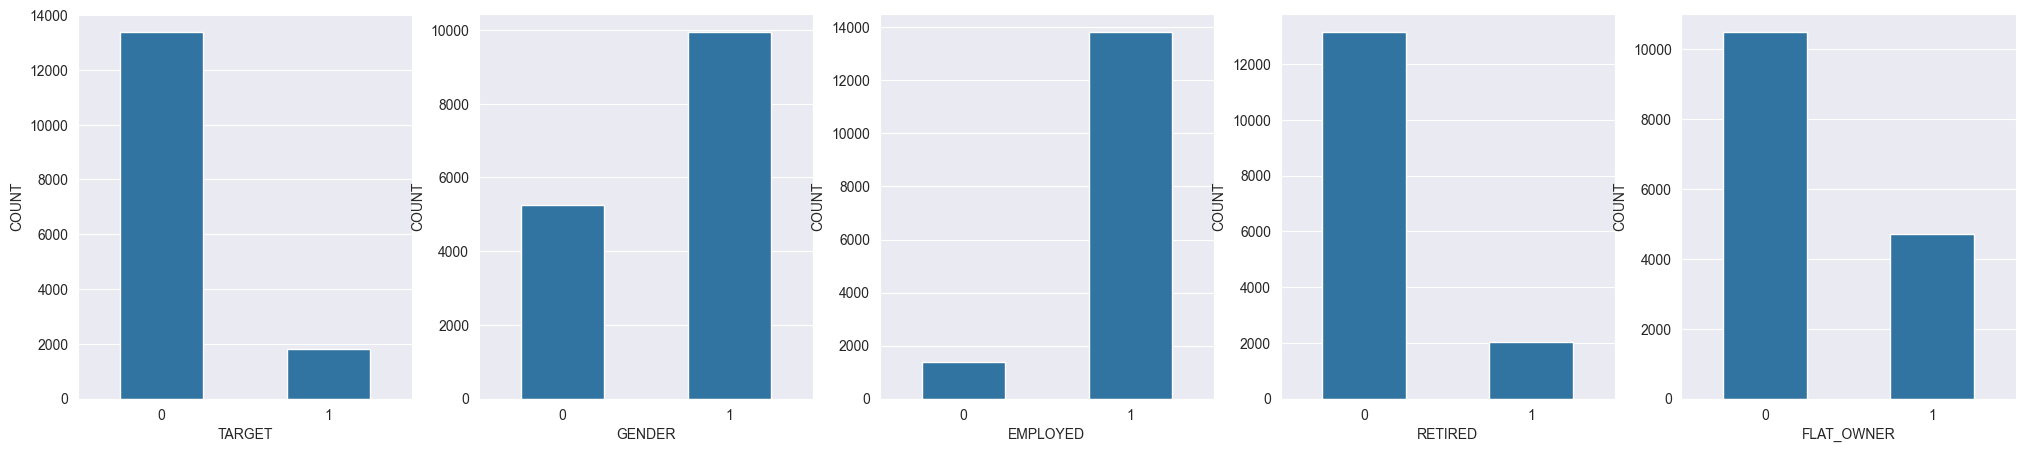

In [47]:
cat_columns = [
    'TARGET',
    'GENDER',
    'EMPLOYED',
    'RETIRED',
    'FLAT_OWNER',
]
    
plt.figure(figsize=(25,5))
for i in range(len(cat_columns)): 
    plt.subplot(1,5,i+1)
    d = result.groupby(cat_columns[i], as_index=False).agg(COUNT = (cat_columns[i],'count'))
    g= sns.barplot(d, x=cat_columns[i], y='COUNT', width=0.5)
    # plt.xticks(rotation = 90)

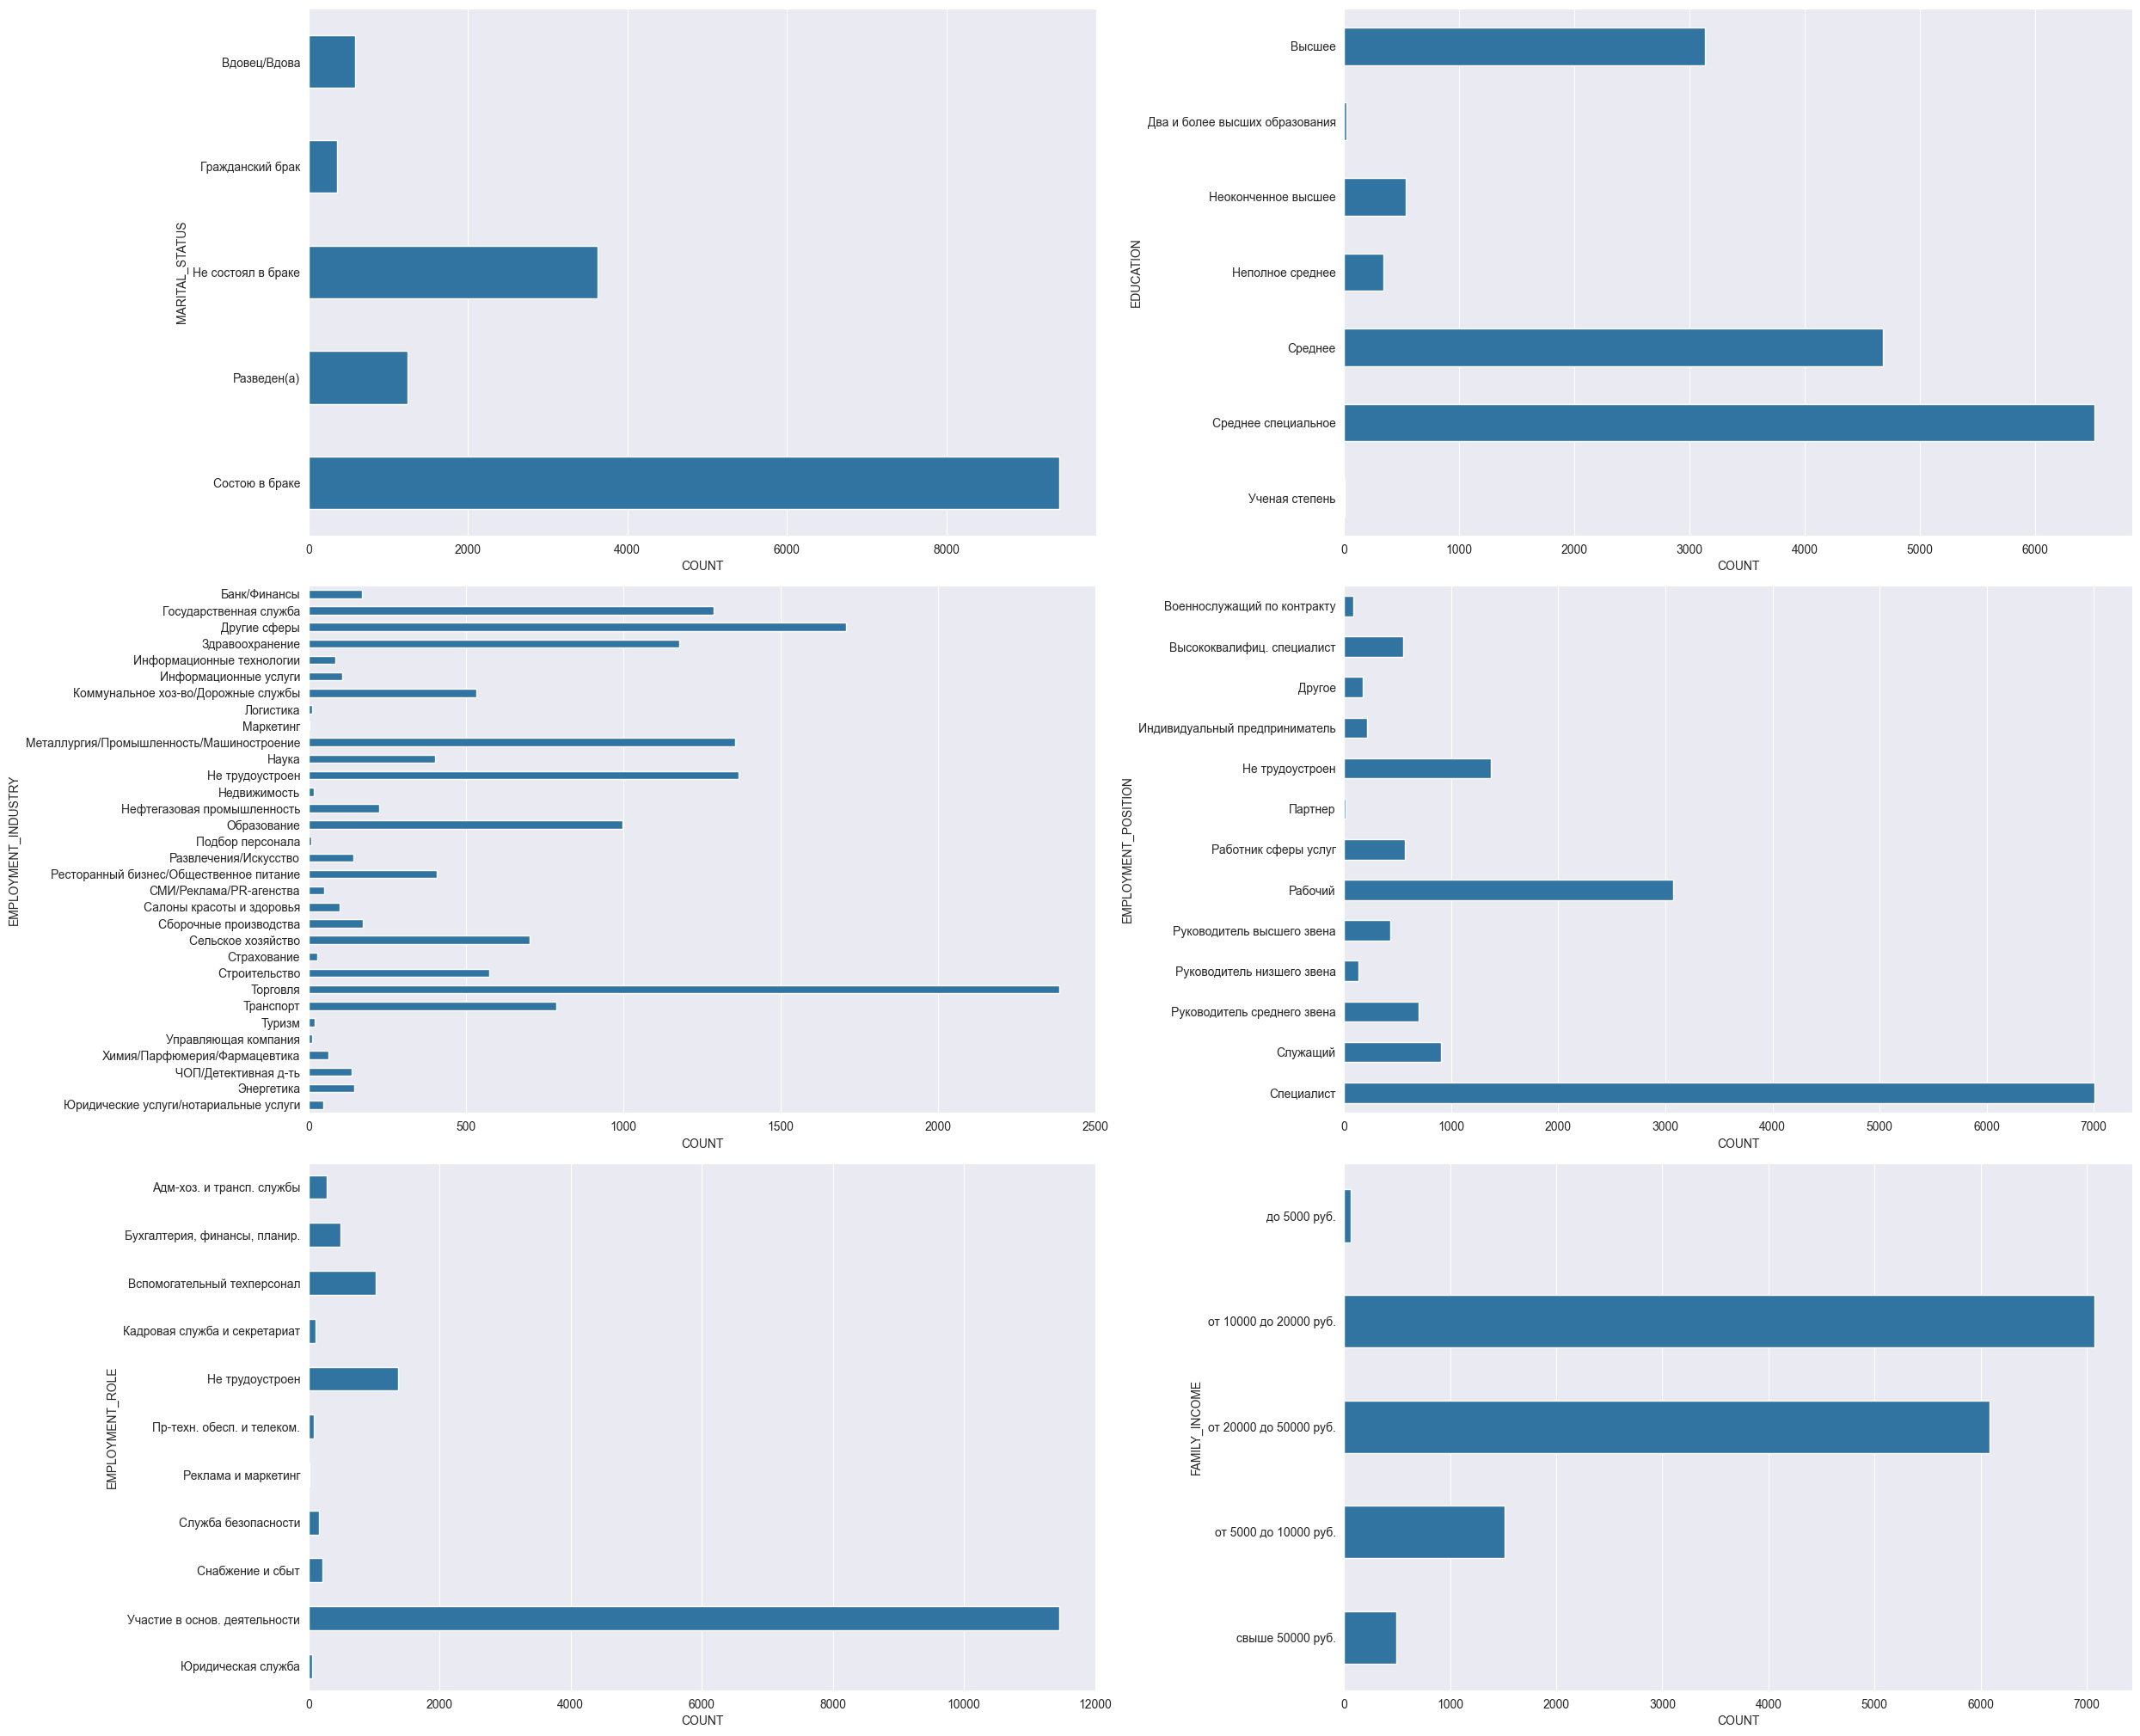

In [23]:
cat_columns = [
    'MARITAL_STATUS',
    'EDUCATION',
    'EMPLOYMENT_INDUSTRY',
    'EMPLOYMENT_POSITION',
    'EMPLOYMENT_ROLE',
    'FAMILY_INCOME'
    #'REG_ADDRESS_PROVINCE',
    #'FACT_ADDRESS_PROVINCE',
    #'POSTAL_ADDRESS_PROVINCE',
]
"""Мы не будем отображать распределение по регионам в адресе, т.к. регионов много, а распределение 
по ним может быть любым. То, что в списке регионов нет странных значений можно проверить вызовом 
value_count() для соответствующего столбца"""

fig = plt.figure(figsize=(25,40))
for i in range(len(cat_columns)): 
    plt.subplot(6,2,i+1)
    d = result.groupby(cat_columns[i], as_index=False).agg(COUNT = (cat_columns[i],'count'))
    sns.barplot(d, y=cat_columns[i], x='COUNT', width=0.5)
fig.tight_layout()

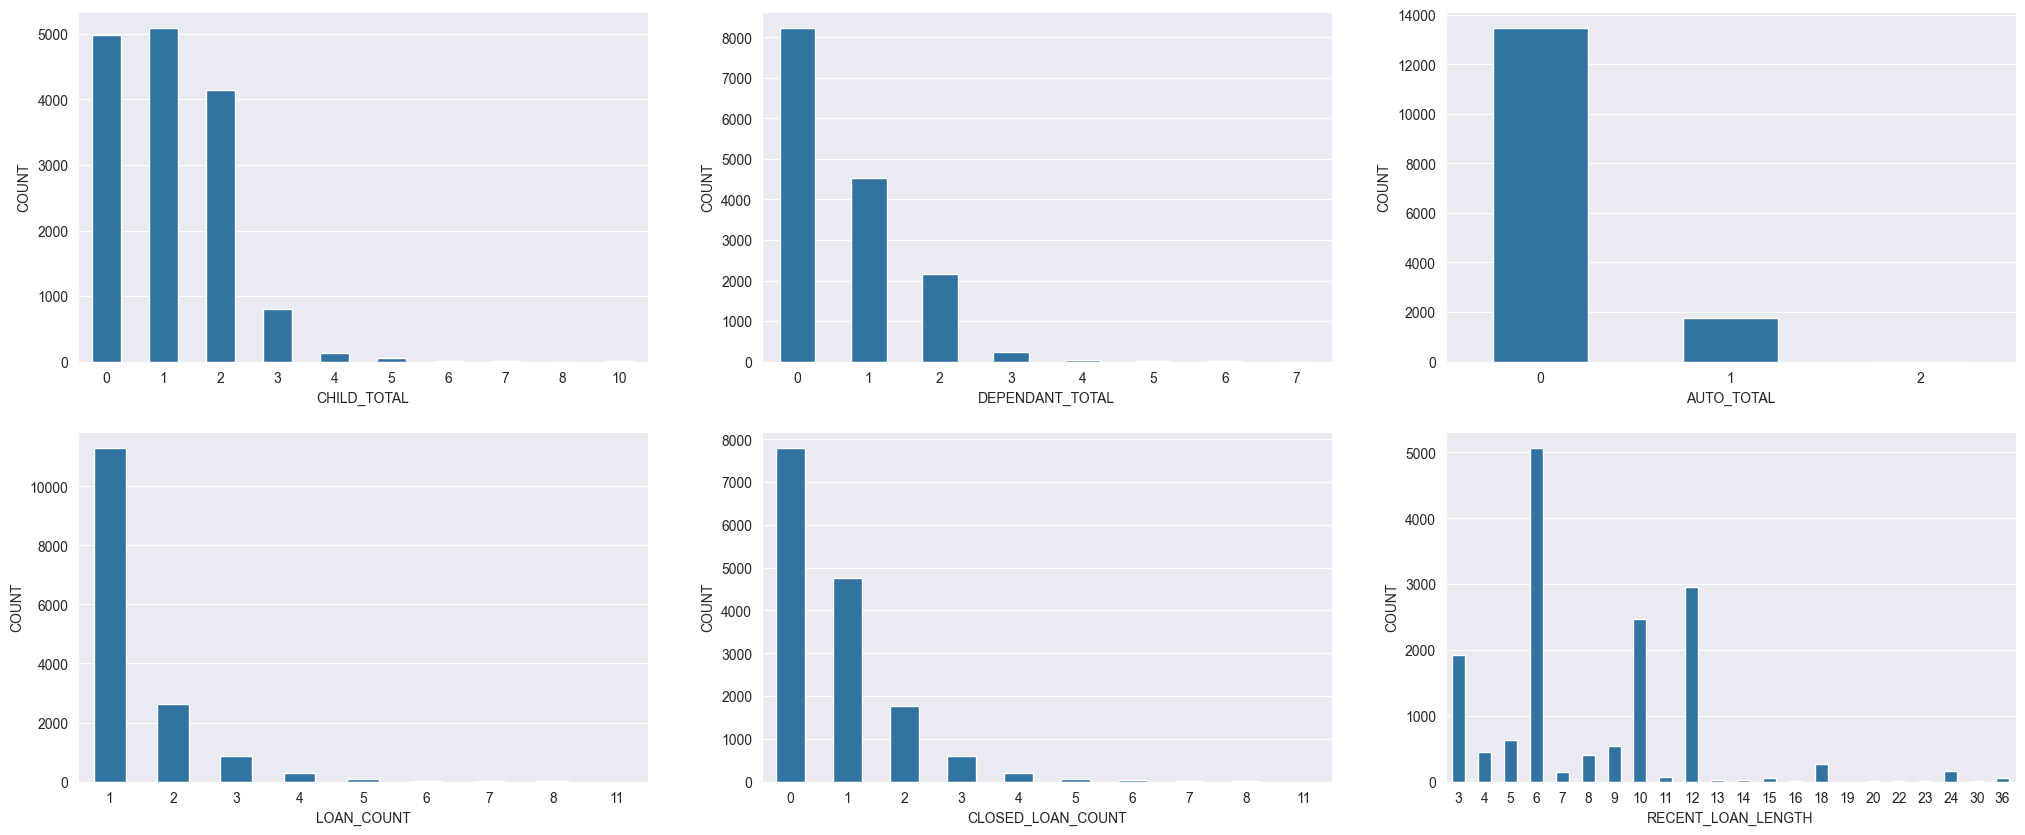

In [24]:
num_columns_discrete = [
    'CHILD_TOTAL',
    'DEPENDANT_TOTAL',
    'AUTO_TOTAL',
    'LOAN_COUNT',
    'CLOSED_LOAN_COUNT',
    'RECENT_LOAN_LENGTH'
]

plt.figure(figsize=(25,10))
for i in range(len(num_columns_discrete)): 
    plt.subplot(2,3,i+1)
    d = result.groupby(num_columns_discrete[i], as_index=False).agg(COUNT = (num_columns_discrete[i],'count'))
    sns.barplot(d, x=num_columns_discrete[i], y='COUNT', width=0.5)

Анализ построенных графиков распределения для категориальных признаков и признаков с ограниченным дискретным множеством значений не показывает чего-то подозрительного. Перейдем к визуализации распределения оставшихся признаков.

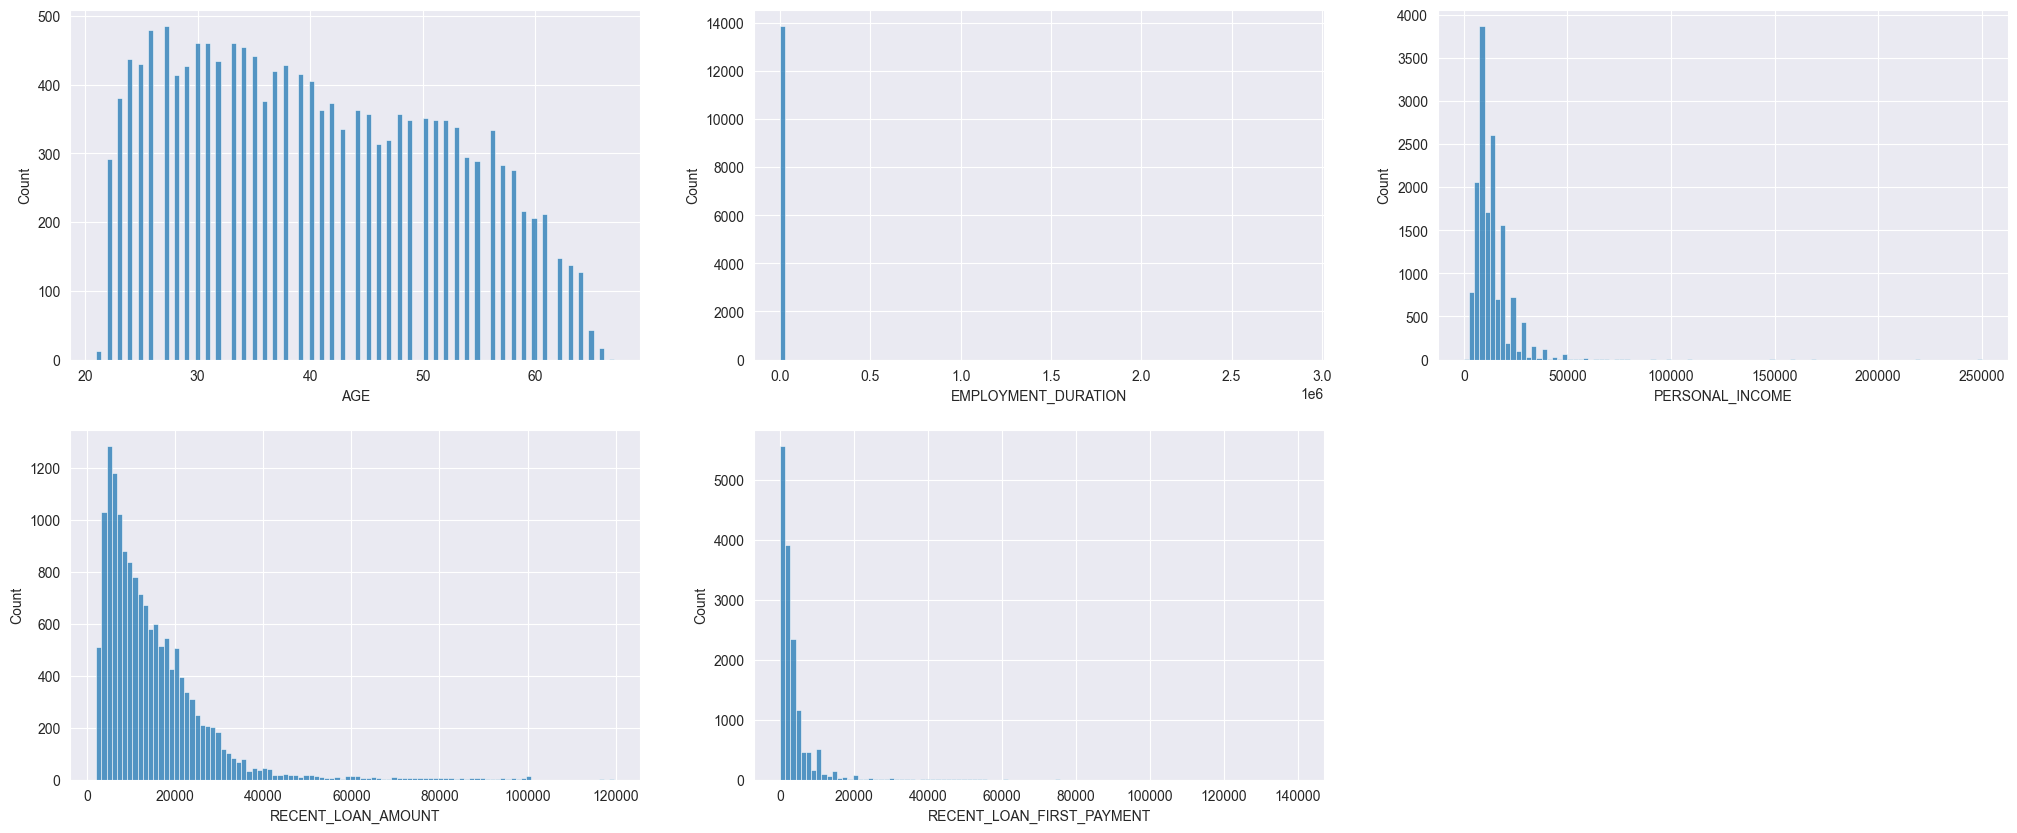

In [25]:
# result = result[result['WORK_TIME'] < 984]
# result = result[result['FST_PAYMENT'] < result['CREDIT']]

num_columns_cont = [
    'AGE',
    'EMPLOYMENT_DURATION',
    'PERSONAL_INCOME',
    'RECENT_LOAN_AMOUNT',
    'RECENT_LOAN_FIRST_PAYMENT',
]

plt.figure(figsize=(25,10))
for i in range(len(num_columns_cont)): 
    plt.subplot(2,3,i+1)
    sns.histplot(data = result, x=num_columns_cont[i], bins=100)

Глядя на графики, можно заметить, что "нормальная" картина имеет место только для признака AGE. На остальных графиках видны "хвосты", что говорит о наличии небольшого количества клиентов банка в выборке с существенно большим значение признака, чем у основной массы клиентов. 

#### Время работы на текущем месте
EMPLOYMENT_DURATION вызывает больше всего вопросов. При этом, для этого параметра можно подобрать рациональную верхнюю границу. Максимальный возраст клиентов выборке - не более 80 лет. Работать человек начинает не раньше 18 лет. Значит максимальное время работы не будет больше (80 - 18) * 12 = 744 месяца. Посмотрим на количество объектов в выборке со значением EMPLOYMENT_DURATION > 744. 

In [26]:
result[result['EMPLOYMENT_DURATION'] > 744].shape

(12, 25)

Видим, что таких объектов всего 12. Вопрос о том, что нужно делать с выбросами не является тривиальным, т.к. любой способ их обработки имеет как достоинства, так и недостатки (например, можно посмотреть [здесь (нужен VPN)](https://www.linkedin.com/pulse/tuesdayeda-handling-outliers-exploratory-data-thomas-reinecke/). Т.к. в данном случае объектов совсем мало, просто удалим их из выборки, заново построим график распределения параметра и убедимся, что его "хвост" теперь не такой внушительный. 

In [27]:
result.drop(result[result['EMPLOYMENT_DURATION'] > 744].index, inplace=True)
result.shape

(15211, 25)

<Axes: xlabel='EMPLOYMENT_DURATION', ylabel='Count'>

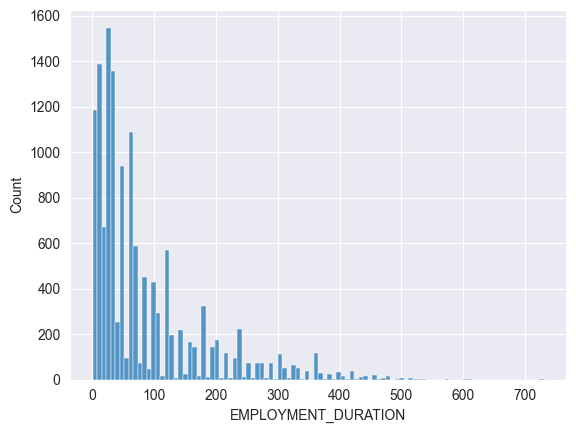

In [28]:
sns.histplot(data = result, x='EMPLOYMENT_DURATION', bins=100)

#### Личный доход
У признака PERSONAL_INCOME также есть небольшое количество больших значений. В данном случае подобрать рациональную верхнюю границу дохода проблематично, поэтому просто посмотрим на количество объектов со значением признака за границей 99.9 перцентиля   

In [29]:
income99_9 = np.nanpercentile(result['PERSONAL_INCOME'], 99.9)
result[result['PERSONAL_INCOME'] > income99_9].shape

(14, 25)

Видим, что объектов снова немного, поэтому аналогично удалим их из выборки и заново построим график распределения

<Axes: xlabel='PERSONAL_INCOME', ylabel='Count'>

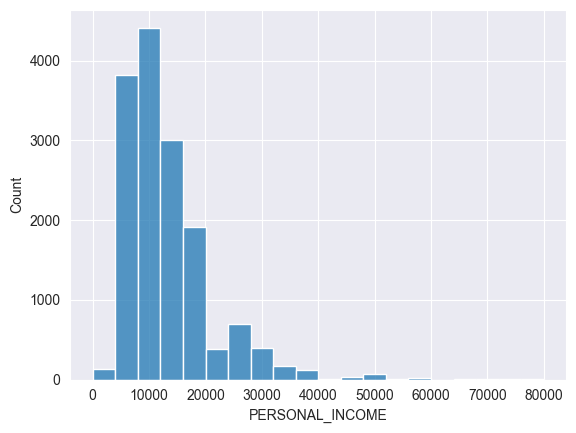

In [30]:
result.drop(result[result['PERSONAL_INCOME'] > income99_9].index, inplace=True)    
sns.histplot(data = result, x='PERSONAL_INCOME', bins=20)

#### Размер последнего кредита и его первоначальный взнос
Для этих признаков также сложно подобрать рациональную границу, поэтому также воспользуемся ~99 перцентилем для определения выбросов.
В результате экспериментов было определено, что для уменьшения хвоста распределения у указанных двух признаков, нужно исключить из выборки объекты, у которых значения признака лежат за границей 99-го перцентиля. Так как таких объектов уже не настолько мало, как в случаях с предыдущими признаками, здесь просто заменим их на NaN, чтобы позже заполнить пропуски (по аналогии с тем, как это сделано в демо-приложении, [ссылка на которое](https://rateyourflight.streamlit.app/) дана в задании) . 

<Axes: xlabel='RECENT_LOAN_AMOUNT', ylabel='Count'>

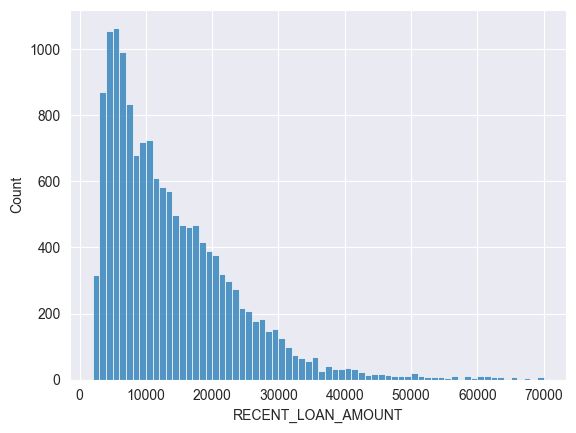

In [31]:
loan_amount99 = np.nanpercentile(result['RECENT_LOAN_AMOUNT'], 99)
result['RECENT_LOAN_AMOUNT'] = np.where(result['RECENT_LOAN_AMOUNT'] > loan_amount99, np.NaN, result['RECENT_LOAN_AMOUNT'])
sns.histplot(result['RECENT_LOAN_AMOUNT'])

<Axes: xlabel='RECENT_LOAN_FIRST_PAYMENT', ylabel='Count'>

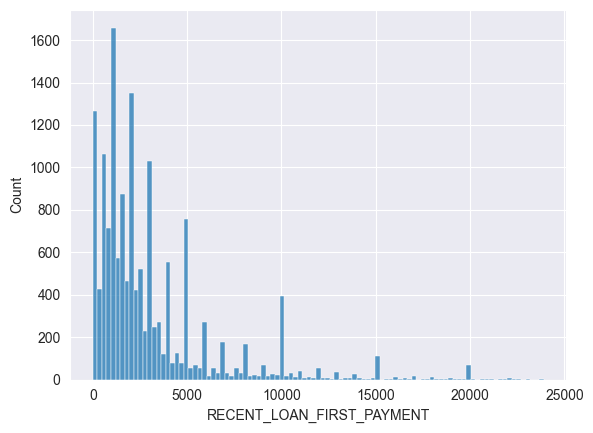

In [32]:
loan_1st_payment99 = np.nanpercentile(result['RECENT_LOAN_FIRST_PAYMENT'], 99)
result['RECENT_LOAN_FIRST_PAYMENT'] = np.where(result['RECENT_LOAN_FIRST_PAYMENT'] > loan_1st_payment99, np.NaN, result['RECENT_LOAN_FIRST_PAYMENT'])
sns.histplot(result['RECENT_LOAN_FIRST_PAYMENT'])

### 2.5 Заполнение оставшихся и добавленных при обработке выбросов пропусков
Посмотрим, в каких столбцах остались или образовались пропуски и заполним их медианными значениями по соответствующим столюцам

In [33]:
nas = result.isna().sum()
nas[nas.values > 0]

EMPLOYMENT_DURATION          1367
RECENT_LOAN_AMOUNT            151
RECENT_LOAN_FIRST_PAYMENT     152
dtype: int64

In [34]:
cols = ['EMPLOYMENT_DURATION', 'RECENT_LOAN_AMOUNT', 'RECENT_LOAN_FIRST_PAYMENT']
for col in cols: 
    result[col].fillna(result[col].median(), inplace=True)
    
nas = result.isna().sum()
nas[nas.values > 0]

Series([], dtype: int64)

### 2.6 Несколько дополнений

НАПИСАТЬ ПРО НЕСООТВЕТСТВИЕ FAMILY_INCOME и PERSONAL_INCOME и про довольно большой процент при сравнении первоначального взноса кредите.

In [899]:
result

,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANT_TOTAL,EMPLOYED,RETIRED,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,...,EMPLOYMENT_POSITION,EMPLOYMENT_ROLE,EMPLOYMENT_DURATION,FAMILY_INCOME,PERSONAL_INCOME,RECENT_LOAN_AMOUNT,RECENT_LOAN_LENGTH,RECENT_LOAN_FIRST_PAYMENT,LOAN_COUNT,CLOSED_LOAN_COUNT
0,42,1,Среднее,Не состоял в браке,1,0,1,0,Московская область,Московская область,...,Работник сферы услуг,Участие в основ. деятельности,3.0,от 20000 до 50000 руб.,25000.0,5588.0,6,1000.0,1,0
1,28,1,Среднее специальное,Состою в браке,1,1,1,0,Читинская область,Читинская область,...,Специалист,Участие в основ. деятельности,5.0,от 10000 до 20000 руб.,10000.0,19498.0,12,0.0,1,0
2,64,0,Среднее специальное,Состою в браке,2,0,1,1,Иркутская область,Иркутская область,...,Руководитель высшего звена,Участие в основ. деятельности,360.0,от 20000 до 50000 руб.,30000.0,15470.0,3,15000.0,1,1
3,54,1,Среднее специальное,Состою в браке,0,0,1,0,Новосибирская область,Новосибирская область,...,Специалист,Участие в основ. деятельности,3.0,от 20000 до 50000 руб.,25000.0,13960.0,6,2500.0,1,0
4,26,0,Среднее специальное,Состою в браке,1,1,1,0,Красноярский край,Красноярский край,...,Специалист,Участие в основ. деятельности,12.0,от 10000 до 20000 руб.,15000.0,11890.0,6,8000.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,26,1,Среднее,Не состоял в браке,1,1,1,0,Чувашия,Чувашия,...,Специалист,Участие в основ. деятельности,36.0,от 5000 до 10000 руб.,8000.0,11750.0,4,1900.0,2,2
15996,26,0,Среднее специальное,Состою в браке,0,0,1,0,Карелия,Карелия,...,Специалист,Участие в основ. деятельности,24.0,от 20000 до 50000 руб.,12000.0,12350.0,6,1380.0,1,0
15997,30,1,Среднее специальное,Не состоял в браке,0,0,1,0,Белгородская область,Белгородская область,...,Специалист,Участие в основ. деятельности,36.0,от 5000 до 10000 руб.,9000.0,4915.0,10,2000.0,1,0
15998,25,0,Среднее специальное,Состою в браке,0,0,1,0,Кабардино-Балкария,Кабардино-Балкария,...,Специалист,Участие в основ. деятельности,36.0,от 10000 до 20000 руб.,12000.0,5860.0,3,2000.0,1,1


In [763]:
result.describe()

,AGE,GENDER,CHILD_TOTAL,DEPENDANT_TOTAL,EMPLOYED,RETIRED,FLAT_OWNER,AUTO_TOTAL,TARGET,EMPLOYMENT_DURATION,PERSONAL_INCOME,RECENT_LOAN_AMOUNT,RECENT_LOAN_LENGTH,RECENT_LOAN_FIRST_PAYMENT,LOAN_COUNT,CLOSED_LOAN_COUNT
count,13830.000000,13830.000000,13830.000000,13830.000000,13830.0,13830.000000,13830.000000,13830.000000,13830.000000,13830.000000,13830.000000,13691.000000,13830.000000,13701.000000,13830.000000,13830.000000
mean,38.755965,0.639335,1.086623,0.696312,1.0,0.048952,0.309111,0.123861,0.127187,83.371945,14291.192853,14197.247688,8.148518,3108.456468,1.397686,0.765654
std,10.653318,0.480211,0.956658,0.822197,0.0,0.215775,0.462144,0.329654,0.333195,91.522185,7956.861939,10154.484092,4.177189,3489.800255,0.805951,1.000957
min,21.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,24.000000,2000.000000,3.000000,0.000000,1.000000,0.000000
25%,30.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,24.000000,9000.000000,6499.000000,6.000000,1000.000000,1.000000,0.000000
50%,38.000000,1.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,48.000000,12000.000000,11601.000000,6.000000,2000.000000,1.000000,0.000000
75%,47.000000,1.000000,2.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,108.000000,17000.000000,19218.000000,10.000000,4000.000000,2.000000,1.000000
max,67.000000,1.000000,10.000000,7.000000,1.0,1.000000,1.000000,2.000000,1.000000,730.000000,80000.000000,71600.000000,36.000000,25000.000000,11.000000,11.000000


In [552]:
result['FAMILY_INCOME'].value_counts()

FAMILY_INCOME
от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1512
свыше 50000 руб.           492
до 5000 руб.                60
Name: count, dtype: int64

In [582]:
import re

min_income_pattern = r'(?<=от)\d+(?=\D)|(?<=свыше)\d+(?=\D)'
max_income_pattern = r'(?<=до)\d+(?=\D)'
MIN_POSSIBLE_INCOME = 0
MAX_POSSIBLE_INCOME = 1000000000
def get_bound(range_str, get_min = True ):
    
    if get_min: 
        pattern = min_income_pattern
        income_boundary = MIN_POSSIBLE_INCOME
    else:
        pattern = max_income_pattern
        income_boundary = MAX_POSSIBLE_INCOME
    
    range_str = range_str.lower().replace(" ","")
    res = re.findall(pattern, range_str)
    return income_boundary if len(res) == 0 else int(res[0])
  
r = pd.DataFrame()
r['min'] = result['FAMILY_INCOME'].apply(lambda v: get_bound(str(v), True)) 
r['max'] = result['FAMILY_INCOME'].apply(lambda v: get_bound(str(v), False))
r['st'] = result['FAMILY_INCOME']
r.drop_duplicates(inplace=True)

result['FAMILY_INCOME_GT'] = result['FAMILY_INCOME'].apply(lambda v: get_bound(str(v), True)) 
result['FAMILY_INCOME_LT'] = result['FAMILY_INCOME'].apply(lambda v: get_bound(str(v), False))

ind = result[result['PERSONAL_INCOME'] > result['FAMILY_INCOME_LT']].index
result.loc[ind]
  
# print(match)
# result['FAMILY_INCOME'].apply(lambda v: re.findall(pattern, v)).value_counts()

# def get_income_boundary(v, get_min = True):
#     vals = re.findall(pattern, v)
#     if len(vals) != 2:
#         if vals == 
        


,AGE,GENDER,EDUCATION,MARITAL_STATUS,CHILD_TOTAL,DEPENDANTS,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,...,FAMILY_INCOME,PERSONAL_INCOME,CREDIT,TERM,FST_PAYMENT,LOAN_COUNT,CLOSED_LOANS,FIRST_PAYMENT_PERCENTAGE,FAMILY_INCOME_GT,FAMILY_INCOME_LT
15,46,1,Среднее,Не состоял в браке,2,0,1,0,Воронежская область,Воронежская область,...,от 5000 до 10000 руб.,55000.0,5835.0,6,1030.00,2,2,17.652099,5000,10000
24,30,1,Высшее,Не состоял в браке,0,0,1,0,Ростовская область,Ростовская область,...,от 5000 до 10000 руб.,15000.0,14796.0,6,3000.00,3,2,20.275750,5000,10000
151,49,0,Среднее,Состою в браке,3,0,1,0,Рязанская область,Рязанская область,...,от 5000 до 10000 руб.,12000.0,35332.0,12,4000.00,2,1,11.321182,5000,10000
268,58,1,Среднее,Не состоял в браке,0,0,0,1,Пензенская область,Пензенская область,...,до 5000 руб.,6500.0,6300.0,6,718.00,2,2,11.396825,0,5000
444,44,0,Среднее специальное,Не состоял в браке,0,0,0,1,Москва,Москва,...,до 5000 руб.,35000.0,17089.9,6,1900.00,1,1,11.117678,0,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,56,1,Среднее,Вдовец/Вдова,0,0,0,1,Камчатская область,Камчатская область,...,до 5000 руб.,11000.0,3285.0,6,365.00,1,0,11.111111,0,5000
15115,49,1,Высшее,Разведен(а),2,1,1,0,Ярославская область,Ярославская область,...,от 10000 до 20000 руб.,25000.0,7500.0,3,500.00,1,1,6.666667,10000,20000
15329,25,1,Среднее специальное,Не состоял в браке,0,0,1,0,Вологодская область,Вологодская область,...,от 10000 до 20000 руб.,100000.0,6750.0,6,1200.00,1,1,17.777778,10000,20000
15524,35,0,Среднее,Состою в браке,0,0,1,0,Тюменская область,Тюменская область,...,от 20000 до 50000 руб.,60000.0,100000.0,12,12144.42,1,1,12.144420,20000,50000


([0, 1, 2, 3, 4],
 [Text(0, 0, 'от 20000 до 50000 руб.'),
  Text(1, 0, 'от 10000 до 20000 руб.'),
  Text(2, 0, 'от 5000 до 10000 руб.'),
  Text(3, 0, 'свыше 50000 руб.'),
  Text(4, 0, 'до 5000 руб.')])

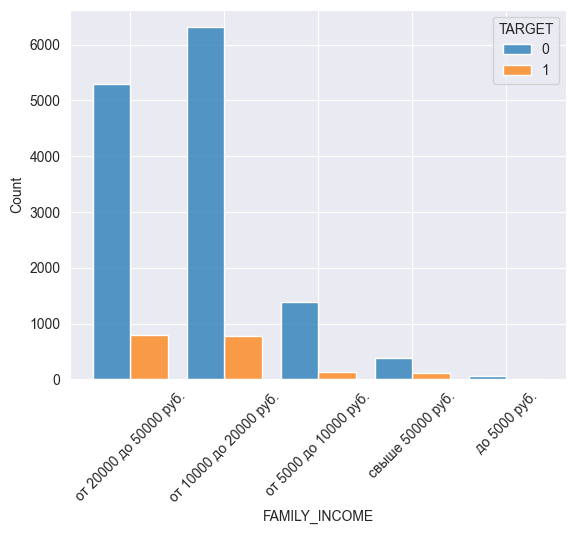

In [589]:
sns.histplot(result, x = 'FAMILY_INCOME', discrete=True, hue='TARGET', multiple="dodge", shrink=.8)
plt.xticks(rotation=45)

<Axes: xlabel='TARGET', ylabel='PERSONAL_INCOME'>

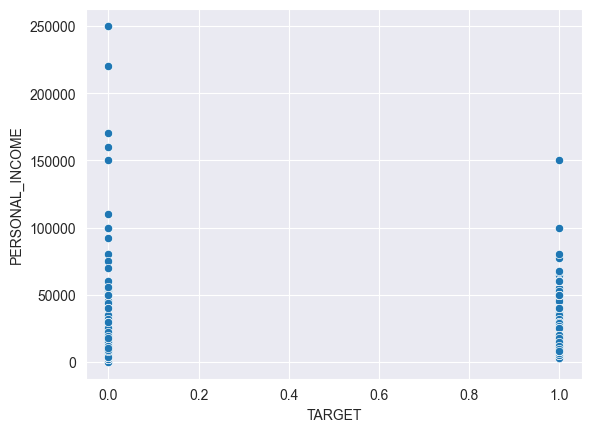

In [593]:
sns.scatterplot(result, y = 'PERSONAL_INCOME', x='TARGET')

In [597]:
r = result.groupby('FAMILY_INCOME', as_index=False).agg(ACCEPTED = ('TARGET', 'sum'), TOTAL = ('TARGET', 'count'))
r['SHARE'] = r['ACCEPTED'] / r['TOTAL']
r.sort_values('SHARE')

,FAMILY_INCOME,ACCEPTED,TOTAL,SHARE
3,от 5000 до 10000 руб.,126,1512,0.083333
0,до 5000 руб.,6,60,0.100000
1,от 10000 до 20000 руб.,769,7077,0.108662
2,от 20000 до 50000 руб.,797,6082,0.131042
4,свыше 50000 руб.,114,492,0.231707


In [598]:
result[['PERSONAL_INCOME','TARGET']].corr()

,PERSONAL_INCOME,TARGET
PERSONAL_INCOME,1.000000,0.094575
TARGET,0.094575,1.000000


### 3. Сохранение датасета для дальнейшего анализа в приложении на Streamlit

In [898]:
result.to_csv('datasets/client_full_data.csv', index=False)


In [911]:
result.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,15197.0,40.404225,11.599019,21.0,30.0,39.00,50.00,67.0
GENDER,15197.0,0.654537,0.475535,0.0,0.0,1.00,1.00,1.0
CHILD_TOTAL,15197.0,1.099493,0.995501,0.0,0.0,1.00,2.00,10.0
DEPENDANT_TOTAL,15197.0,0.645127,0.812153,0.0,0.0,0.00,1.00,7.0
EMPLOYED,15197.0,0.910114,0.286028,0.0,1.0,1.00,1.00,1.0
RETIRED,15197.0,0.134434,0.341130,0.0,0.0,0.00,0.00,1.0
FLAT_OWNER,15197.0,0.309864,0.462452,0.0,0.0,0.00,1.00,1.0
AUTO_TOTAL,15197.0,0.116405,0.320925,0.0,0.0,0.00,0.00,2.0
TARGET,15197.0,0.119037,0.323842,0.0,0.0,0.00,0.00,1.0
EMPLOYMENT_DURATION,15197.0,80.190169,87.893253,1.0,24.0,48.00,96.00,730.0


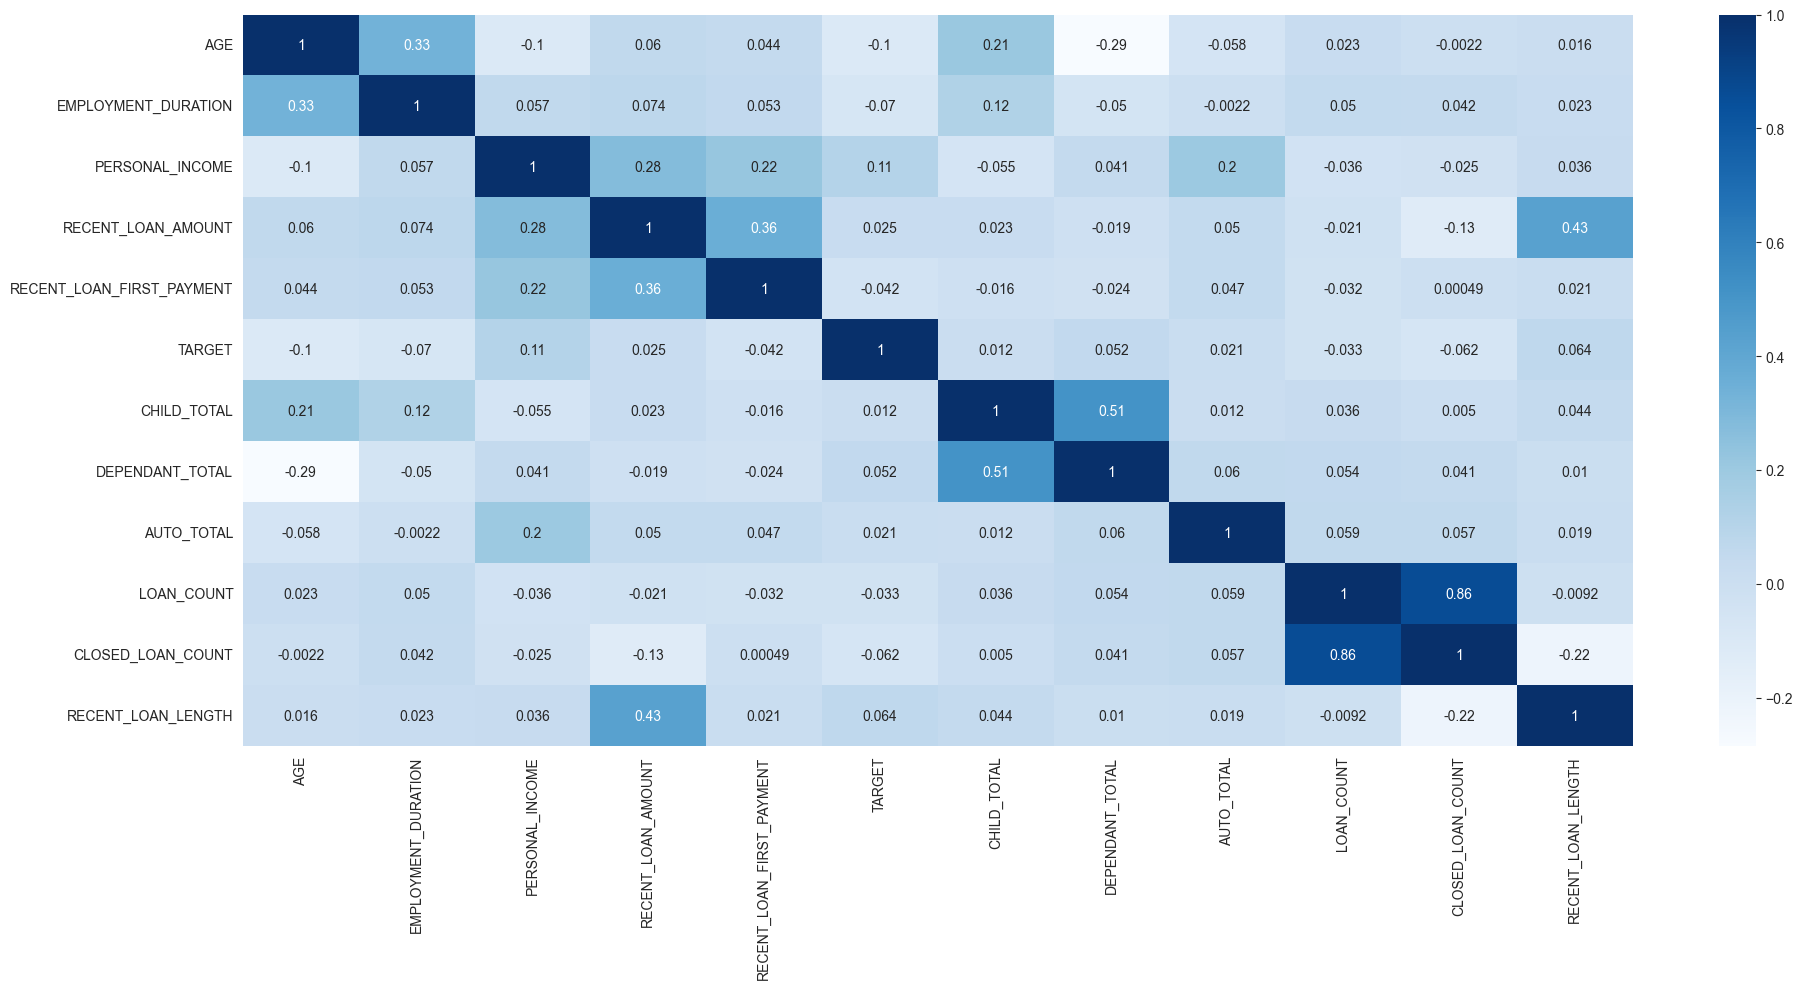

In [41]:
num_columns_cont = [
    'AGE',
    'EMPLOYMENT_DURATION',
    'PERSONAL_INCOME',
    'RECENT_LOAN_AMOUNT',
    'RECENT_LOAN_FIRST_PAYMENT',
    'TARGET']

# f, as= plt.figure(figsize=(10, 10))
# ax = f.subplots(1, 1)
# sns.heatmap(result[num_columns_cont + num_columns_discrete].corr(), annot=True, cmap="Blues", ax=ax)

f = plt.figure(figsize=(20, 10))
ax = f.subplots(1, 1)
sns.heatmap(result[num_columns_cont + num_columns_discrete].corr(), annot=True, cmap="Blues", ax=ax)

# f = plt.figure(figsize=(20, 10))
# ax = f.subplots(2, 3)
# for i in range(len(num_columns_discrete)):
#     d = clients.groupby(num_columns_discrete[i], as_index=False).agg(COUNT=(num_columns_discrete[i], 'count'))
#     sns.heatmap(clients[num_columns_cont + num_columns_discrete].corr(), annot=True, cmap="Blues",
#                 ax=ax[i // 3, i % 3])

f.tight_layout()
# heatmap.show()

# result[num_columns_cont + num_columns_discrete].corr()
# result[num_columns_cont].corr()

<Axes: xlabel='TARGET'>

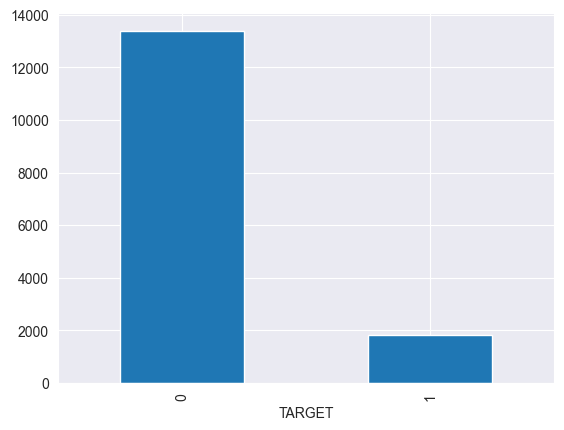

In [59]:
result['TARGET'].value_counts().plot.bar()

In [51]:
result.groupby('REG_ADDRESS_PROVINCE', as_index=False).agg(COUNT = (cat_columns[i],'count')).sort_values('COUNT', ascending=False).head(20)

,REG_ADDRESS_PROVINCE,COUNT
26,Кемеровская область,674
30,Краснодарский край,672
2,Алтайский край,458
75,Читинская область,426
50,Приморский край,416
52,Ростовская область,407
58,Свердловская область,349
11,Волгоградская область,331
56,Саратовская область,330
13,Воронежская область,301
